Here:
- generate time series (cont OU process?)
- plot it (continious and also binned)
- calculate acf: using ABC tau, using py functions
- plot acf

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # comment this line if you don't want to use seaborn for plots

import numpy as np
# IP import warnings because of "module 'numpy' has no attribute 'warnings'"
import warnings
np.warnings = warnings
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit
from scipy import stats

# add the path to the abcTau package
import sys
#sys.path.append('./abcTau')
sys.path.append('C:\\Users\\ipochino\\.conda\\envs\\isttc\\Lib\\site-packages\\abcTau') # IP: replaced previous line with that; relative path was not working
import abcTau

# import from scripts
import os
os.chdir(os.path.expanduser("D:\\intr_timescales\\isttc\\scripts"))
# os.chdir(os.path.expanduser("C:\\Users\\ipoch\\Documents\\repos\\isttc\\scripts"))
from calculate_acf import acf_sttc

In [2]:
def func_exp_abc_like(x, a, tau):
    return a * np.exp(-x/tau) 

### Generate time series

In [40]:
tau = np.array([100])
D = 1/tau
deltaT = 1
T = 100*1000
numTrials = 1

data_mean = 0.001 # average of firing rate
data_var = 0.002 # variance of firing rate

binSize = 50 # bins size for binning the data for calculating acf
binsData =  np.arange(0, T + binSize, binSize)
numBinData = len(binsData)-1
#print(binsData)
print(numBinData)

num_lags = 20
maxTimeLag = 1000 

2000


#### One tau OU

In [41]:
# OU process 
ou = abcTau.OU_gen(tau, D, deltaT, T, numTrials)
print('ou.shape: ', ou.shape)

ou_check = np.max(ou)
print(ou_check)
# adjust OU process - scale, shift 
ou_std = np.sqrt(data_var)
ou_mean = data_mean
ou_all = ou_std * ou + ou_mean # this is scale and shift, where is rectify? - no rectify here, this will come for the Poisson rate
print('ou_all.shape: ', ou_all.shape)

# bin for ACF calculation
ou_binned_data = abcTau.binData(ou_all, [numTrials, numBinData]) * deltaT
print(ou_binned_data.shape)

ou.shape:  (1, 100000)
3.653605577876805
ou_all.shape:  (1, 100000)
(1, 2000)


#### One tau UO with Poisson spike count

In [42]:
ou_std =  np.sqrt(data_var - data_mean)/deltaT # law of total variance  
ou_mean = data_mean/deltaT # law of total expectation

# fit mean and var
ou_poisson = ou_std * ou + ou_mean
ou_poisson[ou_poisson < 0] = 0 # rectifying

# bin rate and generate spikes
numBin = int(T/deltaT)
ou_poisson_rate_ = abcTau.binData(ou_poisson, [numTrials,numBin]) * deltaT
ou_poisson_rate = np.random.poisson(ou_poisson_rate_)

# bin for ACF calculation
ou_poisson_binned = abcTau.binData(ou_poisson_rate, [numTrials, numBinData]) * deltaT
print(ou_poisson_binned.shape)

(1, 2000)


#### Going from rate to spikes

In [43]:
spikeTrain = np.zeros(ou_poisson_rate.shape)
print(spikeTrain.shape)

for i in range(ou_poisson_rate.shape[0]):
    spikeTrain[i,:] = [1 if ou_poisson_rate[i,j] > np.random.random() else 0 for j in range(ou_poisson_rate.shape[1])]

spike_times = np.where(np.squeeze(spikeTrain) == 1)[0]
print('N spikes {}'.format(spike_times.shape))

# bin for ACF calculation
ou_spiketrain_binned = abcTau.binData(spikeTrain, [numTrials, numBinData]) * deltaT
print(ou_spiketrain_binned.shape)

(1, 100000)
N spikes (1353,)
(1, 2000)


### Plot signals

In [ ]:
#ou = np.load('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_data\\ou_tau100ms_1trials_1000ms.npy')

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(20,15))
plt.subplots_adjust(hspace=0.8, wspace=0.4)

axes[0].plot(np.linspace(0,ou.shape[1]-1,ou.shape[1]), ou[0], lw=0.5)
axes[0].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[0].axvline(x=50*i, color='k', lw=0.5)
axes[0].set_xlabel('Time')
axes[0].set_title('One tau OU')

axes[1].plot(np.linspace(0,ou.shape[1]-1,ou.shape[1]), ou_all[0], lw=0.5)
axes[1].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[1].axvline(x=50*i, color='k', lw=0.5)
axes[1].set_xlabel('Time')
axes[1].set_title('One tau OU, scaled and shifted')

# that is supposed to be binned rate but it goes negative? is it ok?
axes[2].plot(np.linspace(0,numBinData-1,numBinData), ou_binned_data[0], lw=0.5)
axes[2].axhline(y=0, color='k', lw=0.5)
axes[2].set_xticks(np.linspace(0,numBinData-1,numBinData))
for i in range(numBinData):
    axes[2].axvline(x=i, color='k', lw=0.5)
axes[2].set_xlabel('Time bins')
axes[2].set_title('One tau OU, scaled and shifted, binned')

sns.despine()

In [ ]:
fig, axes = plt.subplots(5,1, figsize=(10,10))
plt.subplots_adjust(hspace=0.8, wspace=0.4)

axes[0].plot(np.linspace(0,numBin-1,numBin), ou[0], lw=0.5)
axes[0].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[0].axvline(x=50*i, color='k', lw=0.5)
axes[0].set_title('One tau OU')

axes[1].plot(np.linspace(0,numBin-1,numBin), ou_poisson[0], lw=0.5)
axes[1].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[1].axvline(x=50*i, color='k', lw=0.5)
axes[1].set_title('One tau OU, scaled, shifted, rectified')

axes[2].plot(np.linspace(0,numBin-1,numBin), ou_poisson_rate_[0], lw=0.5)
axes[2].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[2].axvline(x=50*i, color='k', lw=0.5)
axes[2].set_title('One tau OU, scaled, shifted, rectified - binned for getting spike count')

axes[3].plot(np.linspace(0,numBin-1,numBin), ou_poisson_rate[0], lw=0.5)
axes[3].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[3].axvline(x=50*i, color='k', lw=0.5)
axes[3].set_title('One tau OU, Poisson spike count')
# for i in range(numBinData+1):
#     axes[3].axvline(x=50*i, color='k', lw=0.5)

# that is supposed to be binned rate but it goes negative? is it ok?
axes[4].plot(np.linspace(0,numBinData-1,numBinData), ou_poisson_binned[0], lw=0.5)
axes[4].axhline(y=0, color='k', lw=0.5)
axes[4].set_xticks(np.linspace(0,numBinData-1,numBinData))
for i in range(numBinData):
    axes[4].axvline(x=i, color='k', lw=0.5)
axes[4].set_title('One tau OU, Poisson spike count binned')


for ax in axes.flat:
    ax.set_xlabel('Time')

sns.despine()

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(20,15))
plt.subplots_adjust(hspace=0.8, wspace=0.4)

axes[0].plot(np.linspace(0,numBin-1,numBin), ou_poisson_rate[0], lw=0.5)
axes[0].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[0].axvline(x=50*i, color='k', lw=0.5)
axes[0].set_title('One tau OU, Poisson spike count')

axes[1].plot(spike_times, np.ones_like(spike_times), '|', markersize=10, c='salmon')  # Plot spikes as a row,
for i in range(numBinData+1):
    axes[1].axvline(x=50*i, color='k', lw=0.5)
axes[1].set_title('One tau OU, Poisson spike train')

axes[2].plot(np.linspace(0,numBinData-1,numBinData), ou_spiketrain_binned[0], lw=0.5)
axes[2].axhline(y=0, color='k', lw=0.5)
axes[2].set_xticks(np.linspace(0,numBinData-1,numBinData))
for i in range(numBinData):
    axes[2].axvline(x=i, color='k', lw=0.5)
axes[2].set_title('One tau OU, Poisson spike train, binned')

for ax in axes.flat:
    ax.set_xlabel('Time')

sns.despine()

### Calculate ACF and taus

In [44]:
# calculate ACF 

# Using ABC
summStat_metric = 'comp_cc'
ifNorm = True # if normalize the autocorrelation or PSD
ou_all_data_sumStat, ou_all_data_mean, ou_all_data_var, ou_all_T, ou_all_numTrials =  abcTau.preprocessing.extract_stats(ou_all, deltaT, binSize,
                                                                                  summStat_metric, ifNorm, maxTimeLag)
print('ou_all_data_mean: {}, ou_all_data_var: {}, ou_all_T: {}, ou_all_numTrials: {}, \n ou_all_data_sumStat: {}'.format(ou_all_data_mean, 
                                                                                                                         ou_all_data_var, 
                                                                                                                         ou_all_T, 
                                                                                                                         ou_all_numTrials, 
                                                                                                                         ou_all_data_sumStat))
# Using acf func
ou_all_acf = acf(ou_binned_data[0], nlags=num_lags)
print('ou_all_acf: {}'.format(ou_all_acf))


# calculate tau

# Using abc but not bayesian
ou_all_abc_popt, ou_all_abc_poptcov = abcTau.preprocessing.fit_oneTauExponential(ou_all_data_sumStat, binSize, maxTimeLag)
print(ou_all_abc_popt)

# Using curve_fit
ou_all_popt, ou_all_pcov = curve_fit(func_exp_abc_like, np.linspace(0,20,21), ou_all_acf, maxfev=5000)
print(ou_all_popt)
ou_all_tau_ms = ou_all_popt[1] * binSize
print(ou_all_tau_ms)

ou_all_data_mean: 0.13767326754371303, ou_all_data_var: 4.350921296359123, ou_all_T: 100000, ou_all_numTrials: 1, 
 ou_all_data_sumStat: [ 1.          0.7128106   0.40841242  0.2269579   0.11452614  0.03856879
 -0.01044278 -0.05216944 -0.08761273 -0.09552449 -0.06106186 -0.02555535
 -0.01367391  0.00780248  0.03466012  0.04665964  0.03534515  0.01553448
 -0.00578638 -0.01439098]
ou_all_acf: [ 1.          0.712454    0.40800302  0.2266159   0.11429536  0.03847071
 -0.01041259 -0.05198803 -0.08726475 -0.09509679 -0.06075887 -0.02541846
 -0.01359679  0.00774495  0.03440744  0.04629264  0.03503535  0.01536955
 -0.0057663  -0.01428206 -0.01027798]
[1. 1.]
[1.05219826 1.92584907]
96.29245349362058


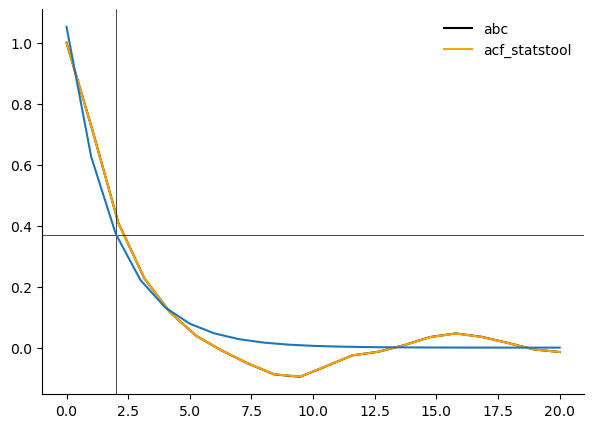

In [45]:
t_axis_lags = np.linspace(0, num_lags*binSize, num_lags)

fig, axes = plt.subplots(1,1, figsize=(7,5))

axes.plot(np.linspace(0,20,20), ou_all_data_sumStat, c='k', label='abc')
axes.plot(np.linspace(0,20,20), ou_all_acf[:-1], c='orange', label='acf_statstool')
axes.axvline(x=2, lw=0.5, color='k')
axes.axhline(y=1/np.e, lw=0.5, color='k')

axes.plot(np.linspace(0,20,21), func_exp_abc_like(np.linspace(0,20,21), ou_all_popt[0], ou_all_popt[1]))

axes.legend(frameon=False)

sns.despine()

In [46]:
# calculate ACF 

# Using ABC
summStat_metric = 'comp_cc'
ifNorm = True # if normalize the autocorrelation or PSD
ou_poisson_data_sumStat, ou_poisson_data_mean, ou_poisson_data_var, ou_poisson_T, ou_poisson_numTrials =  abcTau.preprocessing.extract_stats(ou_poisson_rate, 
                                                                                                                         deltaT, binSize,
                                                                                  summStat_metric, ifNorm, maxTimeLag)
print('ou_poisson_data_mean: {}, ou_poisson_data_var: {}, ou_poisson_T: {}, ou_poisson_numTrials: {}, \n ou_poisson_data_sumStat: {}'.format(ou_poisson_data_mean, 
                                                                                                                         ou_poisson_data_var, 
                                                                                                                         ou_poisson_T, 
                                                                                                                         ou_poisson_numTrials, 
                                                                                                                         ou_poisson_data_sumStat))

# Using acf func
ou_poisson_acf = acf(ou_poisson_binned[0], nlags=num_lags)
print('ou_poisson_acf: {}'.format(ou_poisson_acf))

# calculate tau

# Using abc but not bayesian
ou_poisson_abc_popt, ou_poisson_abc_poptcov = abcTau.preprocessing.fit_oneTauExponential(ou_poisson_data_sumStat, binSize, maxTimeLag)
print(ou_poisson_abc_popt)

# Using curve_fit
ou_poisson_popt, ou_poisson_pcov = curve_fit(func_exp_abc_like, np.linspace(0,20,21), ou_poisson_acf, maxfev=5000)
print(ou_poisson_popt)

ou_poisson_tau_ms = ou_poisson_popt[1] * binSize
print(ou_poisson_tau_ms)

ou_poisson_data_mean: 0.6875, ou_poisson_data_var: 1.45984375, ou_poisson_T: 100000, ou_poisson_numTrials: 1, 
 ou_poisson_data_sumStat: [ 1.00000000e+00  3.27455705e-01  1.62678014e-01  8.98778226e-02
  5.33610419e-03 -6.84139960e-03 -2.49779852e-02 -7.50357298e-04
 -3.49091330e-02 -2.77369441e-02 -1.07024111e-02  1.07647742e-03
  1.18335817e-02 -1.63696651e-03  3.08596355e-02  1.87659740e-02
  2.04710191e-02  5.10620320e-02  2.19277625e-03 -1.66424799e-02]
ou_poisson_acf: [ 1.00000000e+00  3.27291823e-01  1.62514717e-01  8.97423205e-02
  5.32484213e-03 -6.82462806e-03 -2.49036712e-02 -7.47886118e-04
 -3.47746976e-02 -2.76155946e-02 -1.06523601e-02  1.06630633e-03
  1.17574655e-02 -1.63357594e-03  3.06352349e-02  1.86142031e-02
  2.02932677e-02  5.06140961e-02  2.15937065e-03 -1.64976453e-02
  3.48442684e-02]
[1. 1.]
[0.99327055 0.98949243]
49.47462139149224


In [ ]:
fig, axes = plt.subplots(1,1, figsize=(7,5))

axes.plot(np.linspace(0,20,20), ou_poisson_data_sumStat, c='k', label='abc')
axes.plot(np.linspace(0,20,20), ou_poisson_acf[:-1], c='orange', label='acf_statstool')
axes.axvline(x=2, lw=0.5, color='k')
axes.axhline(y=1/np.e, lw=0.5, color='k')
axes.axhline(y=0, lw=0.5, color='k')

axes.plot(np.linspace(0,20,21), func_exp_abc_like(np.linspace(0,20,21), ou_poisson_popt[0], ou_poisson_popt[1]))

axes.legend(frameon=False)

sns.despine()

In [ ]:
spike_times

In [47]:
# calculate ACF 

# Using ABC
summStat_metric = 'comp_cc'
ifNorm = True # if normalize the autocorrelation or PSD
spikeTrain_data_sumStat, spikeTrain_data_mean, spikeTrain_data_var, spikeTrain_T, spikeTrain_numTrials =  abcTau.preprocessing.extract_stats(spikeTrain, 
                                                                                                                         deltaT, binSize,
                                                                                  summStat_metric, ifNorm, maxTimeLag)
print('spikeTrain_data_mean: {}, spikeTrain_data_var: {}, spikeTrain_T: {}, spikeTrain_numTrials: {}, \n spikeTrain_data_sumStat: {}'.format(spikeTrain_data_mean, 
                                                                                                                         spikeTrain_data_var, 
                                                                                                                         spikeTrain_T, 
                                                                                                                         spikeTrain_numTrials, 
                                                                                                                         spikeTrain_data_sumStat))

# Using acf func
spikeTrain_acf = acf(ou_spiketrain_binned[0], nlags=num_lags)
print('ou_poisson_acf: {}'.format(spikeTrain_acf))

# Using sttc
acf_sttc_ = acf_sttc(spike_times, num_lags, lag_shift_=binSize, sttc_dt_=25, signal_length_=T, verbose_=True)
print('acf_sttc: {}'.format(acf_sttc_))

#acf_sttc(signal_, n_lags_, lag_shift_, sttc_dt_, signal_length_, verbose_=True)

# calculate tau

# Using abc but not bayesian
ou_spiketrain_abc_popt, ou_spiketrain_abc_poptcov = abcTau.preprocessing.fit_oneTauExponential(spikeTrain_data_sumStat, binSize, maxTimeLag)
print(ou_spiketrain_abc_popt)

# Using curve_fit
ou_spiketrain_popt, _ = curve_fit(func_exp_abc_like, np.linspace(0,20,21), spikeTrain_acf, maxfev=5000)
print(ou_spiketrain_popt)

ou_spiketrain_tau_ms = ou_spiketrain_popt[1] * binSize
print(ou_spiketrain_tau_ms)

# curvefit and sttc
ou_spiketrain1_popt, _ = curve_fit(func_exp_abc_like, np.linspace(0,20,20), acf_sttc_, maxfev=5000)
print(ou_spiketrain1_popt)
ou_spiketrain1_tau_ms = ou_spiketrain1_popt[1] * binSize
print(ou_spiketrain1_tau_ms)

spikeTrain_data_mean: 0.6765, spikeTrain_data_var: 1.41184775, spikeTrain_T: 100000, spikeTrain_numTrials: 1, 
 spikeTrain_data_sumStat: [ 1.00000000e+00  3.29021250e-01  1.62888646e-01  8.47788404e-02
  8.36488391e-03 -2.44465868e-03 -2.19044697e-02  3.10988276e-04
 -3.00487180e-02 -2.26321723e-02 -6.43384458e-03 -3.04541780e-04
  1.18878267e-02 -1.57277793e-03  2.84635059e-02  2.13066775e-02
  2.09259945e-02  5.14905690e-02 -1.17954733e-03 -1.60035007e-02]
ou_poisson_acf: [ 1.00000000e+00  3.28856581e-01  1.62725122e-01  8.46509630e-02
  8.34753287e-03 -2.43891781e-03 -2.18394347e-02  3.09677247e-04
 -2.99338997e-02 -2.25338994e-02 -6.40526661e-03 -3.07283399e-04
  1.18111790e-02 -1.56885870e-03  2.82568954e-02  2.11369166e-02
  2.07457086e-02  5.10401747e-02 -1.18133860e-03 -1.58633935e-02
  3.04926487e-02]
shift_ms_l [ 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900
 950]
STTC : 1.0
spike_1 (1353,), spike_2 (1351,)
STTC : 0.3598915140491897
spike_1 (1353,), s

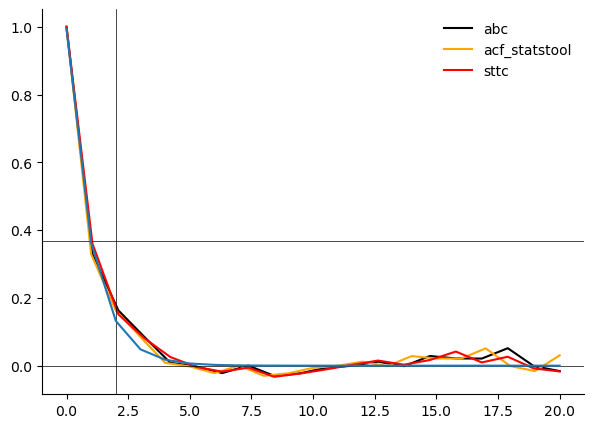

In [48]:
fig, axes = plt.subplots(1,1, figsize=(7,5))

axes.plot(np.linspace(0,20,20), spikeTrain_data_sumStat, c='k', label='abc')
axes.plot(np.linspace(0,20,21), spikeTrain_acf, c='orange', label='acf_statstool')
axes.plot(np.linspace(0,20,20), acf_sttc_, c='red', label='sttc')
axes.axvline(x=2, lw=0.5, color='k')
axes.axhline(y=1/np.e, lw=0.5, color='k')
axes.axhline(y=0, lw=0.5, color='k')

axes.plot(np.linspace(0,20,21), func_exp_abc_like(np.linspace(0,20,21), ou_spiketrain_popt[0], ou_spiketrain_popt[1]))

axes.legend(frameon=False)

sns.despine()

### Schematic of data generation

In [ ]:
# plot
fig, axes = plt.subplots(5,1, figsize=(10,10))
plt.subplots_adjust(hspace=0.8, wspace=0.4)

axes[0].plot(np.linspace(0,numBin-1,numBin), ou[0], lw=0.5)
axes[0].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[0].axvline(x=50*i, color='k', lw=0.5)
axes[0].set_title('One tau OU')

axes[1].plot(np.linspace(0,numBin-1,numBin), ou_poisson[0], lw=0.5)
axes[1].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[1].axvline(x=50*i, color='k', lw=0.5)
axes[1].set_title('One tau OU, scaled, shifted, rectified')

axes[2].plot(np.linspace(0,numBin-1,numBin), ou_poisson_rate[0], lw=0.5)
axes[2].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[2].axvline(x=50*i, color='k', lw=0.5)
axes[2].set_title('One tau OU, Poisson spike count')

axes[3].plot(spike_times, np.ones_like(spike_times), '|', markersize=10, c='salmon')  # Plot spikes as a row,
for i in range(numBinData+1):
    axes[3].axvline(x=50*i, color='k', lw=0.5)
axes[3].set_title('One tau OU, Poisson spike train')

axes[4].plot(np.linspace(0,numBinData-1,numBinData), ou_spiketrain_binned[0], lw=0.5)
axes[4].axhline(y=0, color='k', lw=0.5)
axes[4].set_xticks(np.linspace(0,numBinData-1,numBinData))
for i in range(numBinData):
    axes[4].axvline(x=i, color='k', lw=0.5)
axes[4].set_title('One tau OU, Poisson spike train, binned')

for ax in axes.flat:
    ax.set_xlabel('Time')

sns.despine()

#fig.savefig('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\' + 'data_generation_schematic.png' , bbox_inches='tight')